### Comparing llm and human paths

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib
import seaborn as sns

## Path with no memory

In [9]:
# load the data data/llm_paths_all_gpt4omini_no_memory.tsv
llm_paths_all_gpt4omini_no_memory = pd.read_csv('data/llm_paths_all_gpt4omini_no_memory.tsv', sep='\t')

1. Does the llm take on average more steps than the human?

In [3]:
# As we created the data, we made the number of steps to be 0 if the path was unsuccessful. For this analysis, we will filter out the rows with 0 steps.
# filter out the rows with 0 steps
llm_paths_all_gpt4omini_no_memory = llm_paths_all_gpt4omini_no_memory[llm_paths_all_gpt4omini_no_memory['steps'] > 0]
# describe the data
llm_paths_all_gpt4omini_no_memory['steps'].describe()

count    14527.000000
mean         3.661527
std          1.612817
min          1.000000
25%          3.000000
50%          3.000000
75%          5.000000
max         16.000000
Name: steps, dtype: float64

In [5]:
# we will compare the llm to the human data so let's load the human data!
# load the data data/paths_finished_unique.tsv
paths_finished = pd.read_csv('data/paths_finished_unique.tsv', sep='\t')

# get the number of steps in the finished paths
paths_finished['path_length'] = paths_finished['path'].apply(lambda x: len(x.split(';')) - 1)
paths_finished['path_length'].describe()

count    28718.000000
mean         5.672749
std          5.017178
min          0.000000
25%          3.000000
50%          5.000000
75%          7.000000
max        434.000000
Name: path_length, dtype: float64

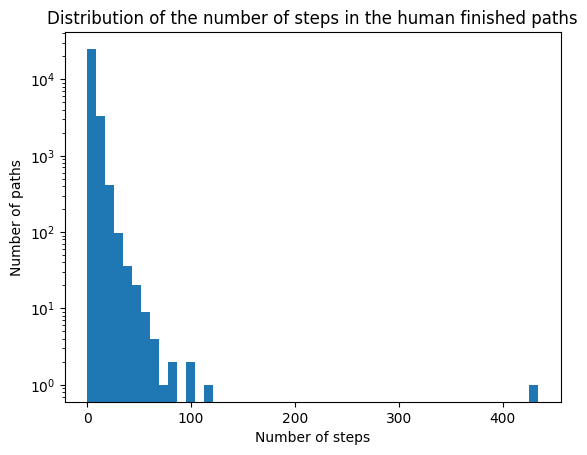

In [11]:
# plot the distribution of the number of steps in the finished paths
paths_finished['path_length'].hist(bins=50)
plt.xlabel('Number of steps')
plt.ylabel('Number of paths')
plt.title('Distribution of the number of steps in the human finished paths')
plt.grid(False)
plt.yscale('log')

In [12]:
# we created a column that contains the number of steps in the path. 
llm_paths_all_gpt4omini_no_memory['path_length'] = llm_paths_all_gpt4omini_no_memory['path'].apply(lambda x: len(x.split(';')) - 1)

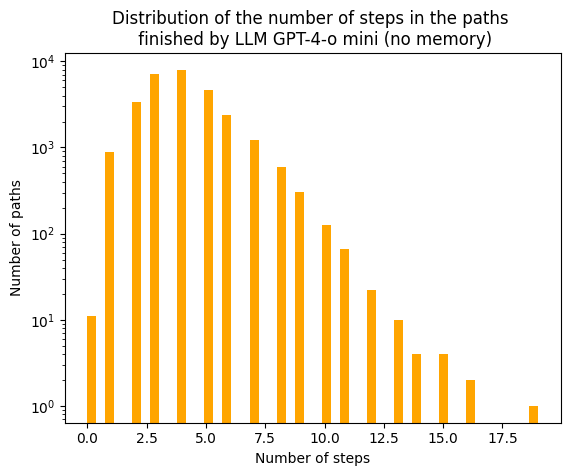

In [13]:
llm_paths_all_gpt4omini_no_memory['path_length'].hist(color='orange', bins=50)
plt.xlabel('Number of steps')
plt.ylabel('Number of paths')
plt.title('Distribution of the number of steps in the paths \n finished by LLM GPT-4-o mini (no memory)')
plt.grid(False)
plt.yscale('log')

In [15]:
# To have a good comparaison we wanted to take only the path_id that are in the 2 datasets
# create a mask using the past_id column
mask = paths_finished['path_id'].isin(llm_paths_all_gpt4omini_no_memory['path_id'])
paths_finished_filtered = paths_finished[mask]


# get the number of steps in the filtered paths
paths_finished_filtered['path_length'] = paths_finished_filtered['path'].apply(lambda x: len(x.split(';')) - 1)
paths_finished_filtered['path_length'].describe()


count    28718.000000
mean         5.672749
std          5.017178
min          0.000000
25%          3.000000
50%          5.000000
75%          7.000000
max        434.000000
Name: path_length, dtype: float64

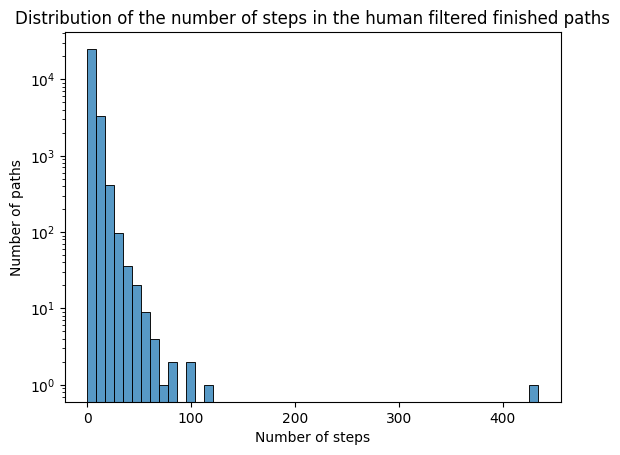

In [16]:
# plot the distribution of the number of steps in the filtered paths
sns.histplot(paths_finished_filtered['path_length'], bins=50)
plt.title('Distribution of the number of steps in the human filtered finished paths')
plt.xlabel('Number of steps')
plt.ylabel('Number of paths')
plt.yscale('log')

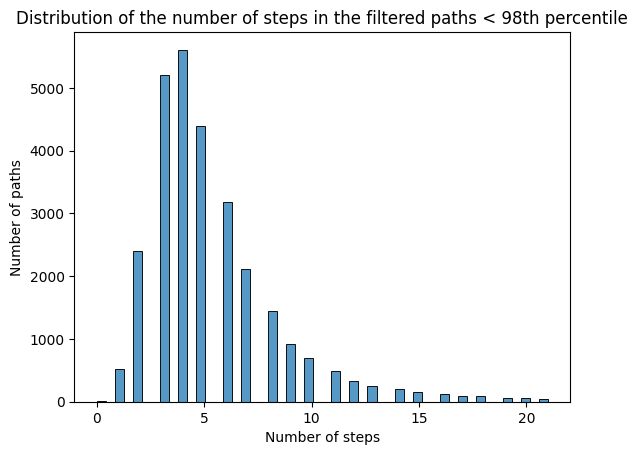

In [17]:
# We can easily identify outliers in the human dataset. Therefore we choose to get the 98th percentile of the number of steps in the filtered paths
percentile_99 = np.percentile(paths_finished_filtered['path_length'], 99)
# plot the distribution of the number of steps in the filtered paths that are less than the 98th percentile
paths_finished_filtered_lt_99 = paths_finished_filtered[paths_finished_filtered['path_length'] < percentile_99]
sns.histplot(paths_finished_filtered_lt_99['path_length'], bins=50)
plt.title('Distribution of the number of steps in the filtered paths < 98th percentile')
plt.xlabel('Number of steps')
plt.ylabel('Number of paths')
plt.show()

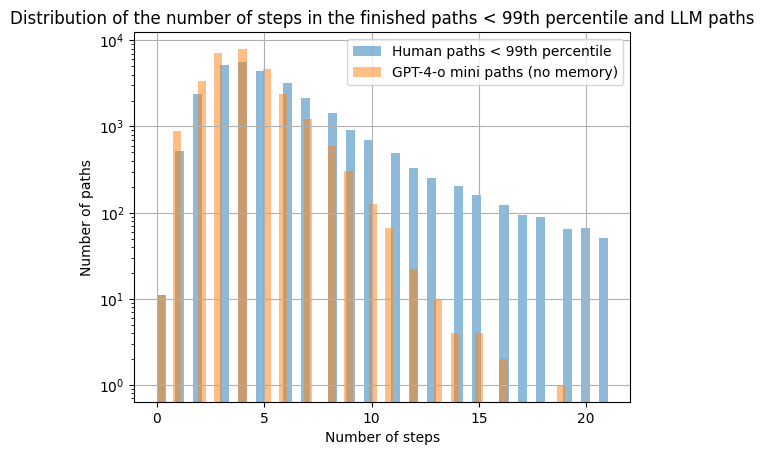

In [18]:
# compare the distribution of the number of steps in the finished paths filtered 99 percentile and the LLM paths
paths_finished_filtered_lt_99['path_length'].hist(bins=50, alpha=0.5, label='Human paths < 99th percentile')
llm_paths_all_gpt4omini_no_memory['path_length'].hist(bins=50, alpha=0.5, label='GPT-4-o mini paths (no memory)')
plt.title('Distribution of the number of steps in the finished paths < 99th percentile and LLM paths')
plt.xlabel('Number of steps')
plt.ylabel('Number of paths')
plt.legend()
plt.yscale('log')
plt.show()

2. How does the llm work for unfinished paths?

In [19]:
# load the data of unfinished paths
DATA_FOLDER = 'data/wikispeedia_paths-and-graph/'
paths_unfinished = pd.read_csv(DATA_FOLDER + 'paths_unfinished.tsv', sep='\t', skiprows=16, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type'])
paths_unfinished['path'] = paths_unfinished['path'].map(urllib.parse.unquote)

In [22]:
# for each row add a column containing the pair of the first article in the path and the target article
paths_unfinished['pair'] = paths_unfinished['path'].apply(lambda x: x.split(';')[0]) + ' -> ' + paths_unfinished['target']
# create a subset of the data by taking only one ocurrence of each pair
paths_unfinished_unique = paths_unfinished.drop_duplicates(subset='pair')

In [95]:
# Now for the finished paths, we will do the same thing
# for each row add a column containing the pair of the first article in the path and the target article
paths_finished['pair'] = paths_finished['path'].apply(lambda x: x.split(';')[0] + ' -> ' + x.split(';')[-1])


In [ ]:
# Some users fail a path that is succeed by another one. To avoid running the same path again, we will filter out the paths that are finished by some other user.
# get the paths_unfinished_unique that are not in the paths_finished_unique
mask = ~paths_unfinished_unique['pair'].isin(paths_finished['pair'])
paths_unfinished_unique_filtered = paths_unfinished_unique[mask]

print(paths_unfinished_unique_filtered.head())
# get the number of unique paths_unfinished_unique_filtered
print(paths_unfinished_unique_filtered['pair'].nunique())

# store the paths_unfinished_unique_filtered
paths_unfinished_unique_filtered.to_csv('data/paths_unfinished_unique_filtered.tsv', sep='\t', index=False)

Percentage of loop detected  0.4484240687679083
Percentage of wrong answer  0.17765042979942694
Percentage of dead end  0.06876790830945559
Percentage of finished paths  0.30515759312320917


Text(0.5, 1.0, 'Outcome of the paths generated by LLM on unfinished paths by humans')

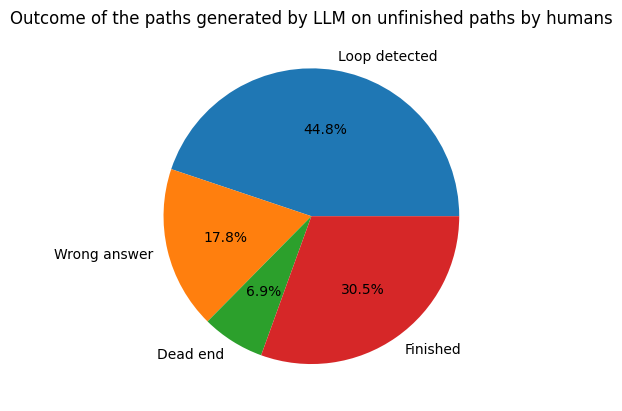

In [23]:
# After running the LLM on the paths_unfinished_unique_filtered, using the same script as before, we get the data/llm_on_paths_unfinished.tsv
llm_paths_unfinished = pd.read_csv('data/llm_on_paths_unfinished.tsv', sep='\t')

# get the number of loop_detetected
# in the path column, if the last element is LOOP_DETECTED, then it is a loop
llm_paths_unfinished['loop_detected'] = llm_paths_unfinished['path'].apply(lambda x: x.split(';')[-1] == 'LOOP_DETECTED')


# get the number of wrong_answer
# in the path column, if the last element is WRONG_ANSWER, then it is a wrong answer
llm_paths_unfinished['wrong_answer'] = llm_paths_unfinished['path'].apply(lambda x: x.split(';')[-1] == 'WRONG_ANSWER')


# get the number of paths that goes to a link with dead end
# in the path column, if the last element is NO_LINK, then it is a dead end
llm_paths_unfinished['no_link'] = llm_paths_unfinished['path'].apply(lambda x: x.split(';')[-1] == 'NO_LINK')

# get the number of paths that finishes i.e. there is no LOOP_DETECTED, WRONG_ANSWER or NO_LINK
llm_paths_unfinished['finished'] = ~(llm_paths_unfinished['loop_detected'] | llm_paths_unfinished['wrong_answer'] | llm_paths_unfinished['no_link'])



# print the percentage of each
print("Percentage of loop detected ",llm_paths_unfinished['loop_detected'].sum() / len(llm_paths_unfinished))
print("Percentage of wrong answer ",llm_paths_unfinished['wrong_answer'].sum() / len(llm_paths_unfinished))
print("Percentage of dead end ",llm_paths_unfinished['no_link'].sum() / len(llm_paths_unfinished))
print("Percentage of finished paths ",llm_paths_unfinished['finished'].sum() / len(llm_paths_unfinished))

labels = 'Loop detected', 'Wrong answer', 'Dead end', 'Finished'
sizes = [llm_paths_unfinished['loop_detected'].sum(), llm_paths_unfinished['wrong_answer'].sum(), llm_paths_unfinished['no_link'].sum(), llm_paths_unfinished['finished'].sum()]
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Outcome of the paths generated by LLM on unfinished paths by humans')


In [24]:
# filter out the rows with 0 steps to filter the unfinished paths
llm_paths_unfinished = llm_paths_unfinished[llm_paths_unfinished['steps'] > 0]
# describe the data
llm_paths_unfinished['steps'].describe()

count    426.000000
mean       5.661972
std        3.545776
min        1.000000
25%        3.000000
50%        5.000000
75%        7.000000
max       25.000000
Name: steps, dtype: float64

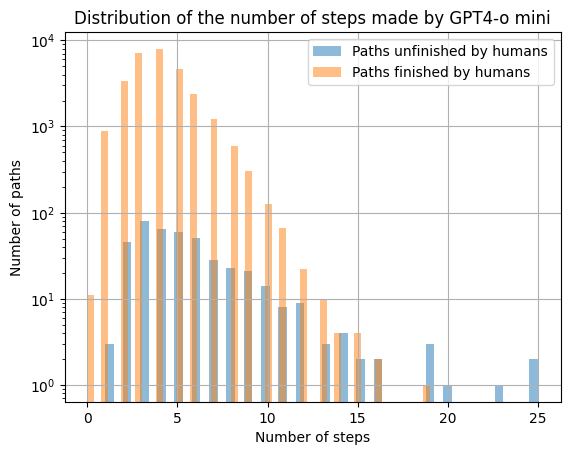

In [ ]:
# we compare the number of steps of paths made by the llm by classifying them by the fact that the human finished or unfinished the corresponding path
llm_paths_unfinished['steps'].hist(bins=50, alpha=0.5, label='Paths unfinished by humans')
llm_paths_all_gpt4omini_no_memory['path_length'].hist(bins=50, alpha=0.5, label='Paths finished by humans')
plt.title('Distribution of the number of steps made by GPT4-o mini')
plt.xlabel('Number of steps')
plt.ylabel('Number of paths')
plt.legend()
plt.yscale('log')
plt.show()

3. What is the distribution of the categories of articles passed by the llm or by the human?

In [27]:
# We reload the data (it was modify to get only the successful paths)
# get the articles that llm goes to
llm_paths_all_gpt4omini_no_memory = pd.read_csv('data/llm_paths_all_gpt4omini_no_memory.tsv', sep='\t')
# get the categories of the articles
file_path = "data/wikispeedia_paths-and-graph/categories.tsv"
categories = pd.read_csv(file_path, sep='\t', skiprows=12, names=['article', 'category'])
categories = categories.map(urllib.parse.unquote)

In [28]:

# get the articles that human goes to
articles_llm = llm_paths_all_gpt4omini_no_memory['path'].apply(lambda x: x.split(';')).tolist()

# ignore the "<" articles in the path
articles_llm = [[item for item in sublist if item[0] != '<'] for sublist in articles_llm]

articles_llm = [item for sublist in articles_llm for item in sublist]
# get the categories of the articles
categories_of_articles_llm = []
for article in articles_llm:
    try:
        categories_of_articles_llm.append(categories[categories['article'] == article]['category'])
    except:
        pass


# using the value counts, get the 0.70 quantile of the categories
categories_of_articles_llm = [item for sublist in categories_of_articles_llm for item in sublist]
categories_count_llm = pd.Series(categories_of_articles_llm).value_counts()

# print the 5 most common categories
print(categories_count_llm.head())
nbr = categories_count_llm.quantile(0.70)

subject.Countries                                          17316
subject.Science.Biology.General_Biology                     7016
subject.Geography.European_Geography.European_Countries     6374
subject.Geography.Geography_of_Great_Britain                5235
subject.Geography.North_American_Geography                  4791
Name: count, dtype: int64


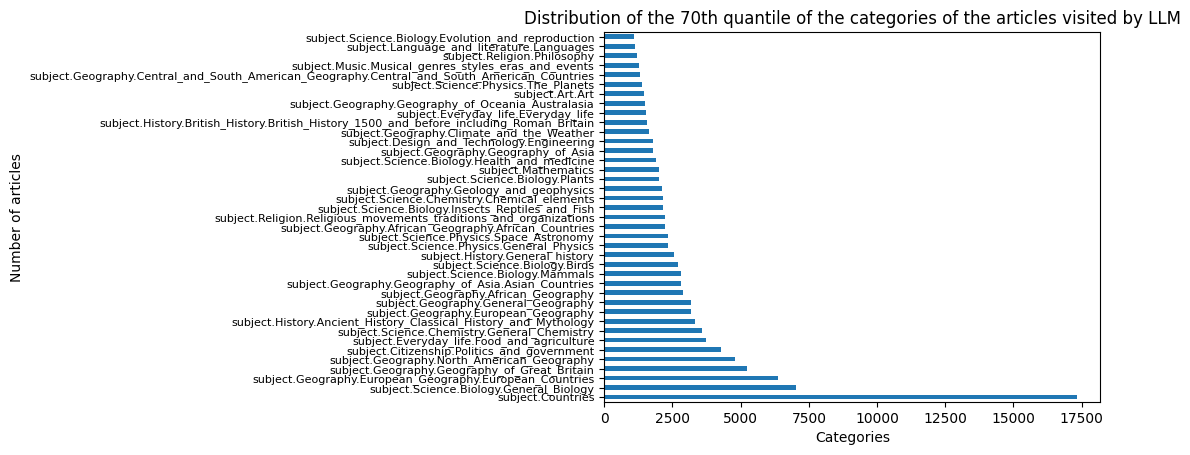

In [29]:
# plot the distribution of the 70th quantile to avoid outliers
categories_count_llm[categories_count_llm > nbr].plot(kind='barh')
plt.title('Distribution of the 70th quantile of the categories of the articles visited by LLM')
plt.ylabel('Number of articles')
plt.xlabel('Categories')
plt.yticks(fontsize=8)
plt.show()

In [30]:
# get the articles that human goes to
articles_human = paths_finished['path'].apply(lambda x: x.split(';')).tolist()

# ignore the "<" articles in the path
articles_human = [[item for item in sublist if item[0] != '<'] for sublist in articles_human]

articles_human = [item for sublist in articles_human for item in sublist]
# get the categories of the articles
categories_of_articles_human = []
for article in articles_human:
    try:
        categories_of_articles_human.append(categories[categories['article'] == article]['category'])
    except:
        pass


# using the value counts, get the 0.70 quantile of the categories
categories_of_articles_human = [item for sublist in categories_of_articles_human for item in sublist]
categories_count_human = pd.Series(categories_of_articles_human).value_counts()

# print the 5 most common categories
print(categories_count_human.head())
nbr_h = categories_count_human.quantile(0.70)

subject.Countries                                          25739
subject.Geography.North_American_Geography                 10157
subject.Geography.European_Geography.European_Countries     9503
subject.Geography.Geography_of_Great_Britain                8169
subject.Geography.General_Geography                         6106
Name: count, dtype: int64


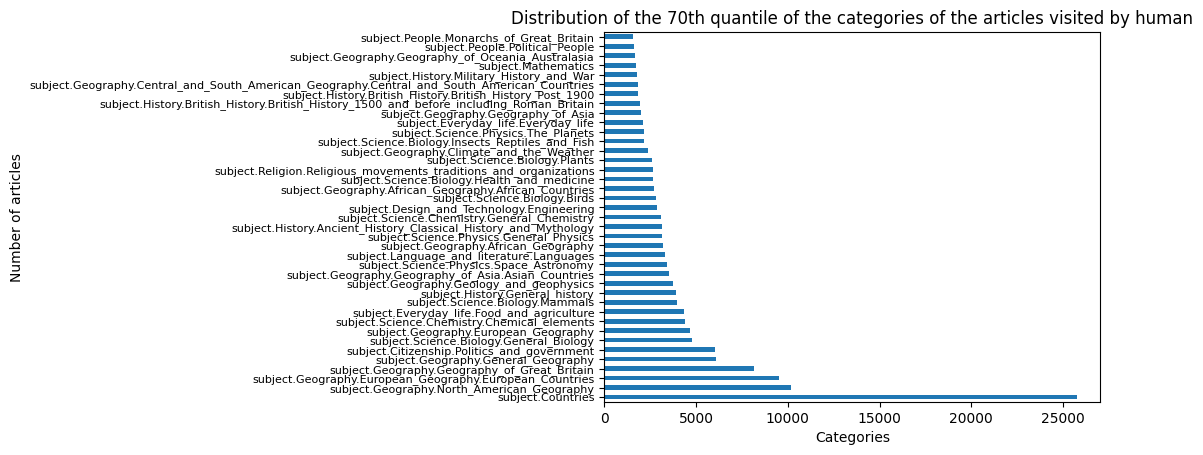

In [31]:
# plot the distribution of the 70th quantile
categories_count_human[categories_count_human > nbr_h].plot(kind='barh')
plt.title('Distribution of the 70th quantile of the categories of the articles visited by human')
plt.ylabel('Number of articles')
plt.xlabel('Categories')
plt.yticks(fontsize=8)
plt.show()

4. What is the distribution of the articles passed by the llm or by the human?

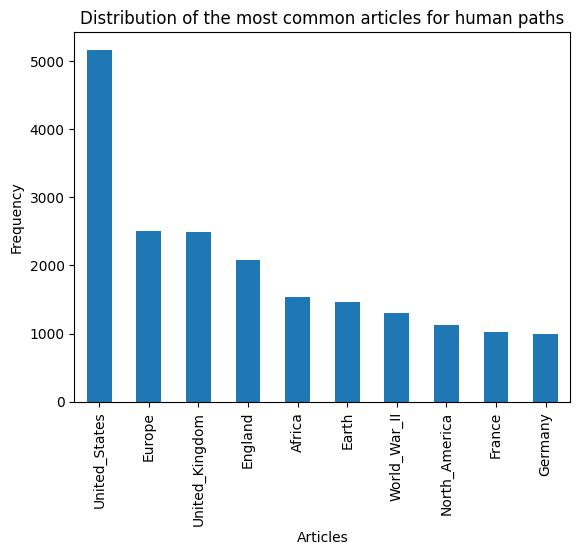

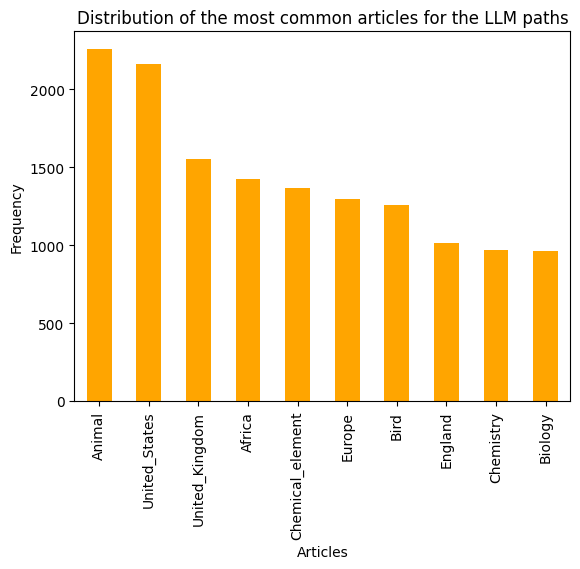

In [32]:

# Plot the distribution of the most common articles
articles_count_h = pd.Series(articles_human)
articles_count_h = articles_count_h.value_counts()
articles_count_h = articles_count_h.sort_values(ascending=False)
articles_count_h = articles_count_h[:10]
articles_count_h.plot(kind='bar')
plt.title('Distribution of the most common articles for human paths')
plt.xlabel('Articles')
plt.ylabel('Frequency')
plt.show()


# from articles_llm, drop the loop_detected, wrong_answer and no_link
articles_llm = [item for item in articles_llm if item not in ['LOOP_DETECTED', 'WRONG_ANSWER', 'NO_LINK']]


# Plot the distribution of the most common articles
articles_count = pd.Series(articles_llm)
articles_count = articles_count.value_counts()
articles_count = articles_count.sort_values(ascending=False)
articles_count = articles_count[:10]
articles_count.plot(kind='bar', color='orange')
plt.title('Distribution of the most common articles for the LLM paths')
plt.xlabel('Articles')
plt.ylabel('Frequency')
plt.show()



In [42]:
# plot a comparison of the 10 most common articles of the llm and the human
print(articles_count_h)
print(articles_count)

print("the number of articles passes from human", articles_count_h.sum())
print(articles_count.sum())


United_States     5163
Europe            2502
United_Kingdom    2489
England           2073
Africa            1537
Earth             1456
World_War_II      1305
North_America     1128
France            1026
Germany            990
Name: count, dtype: int64
Animal              2259
United_States       2161
United_Kingdom      1553
Africa              1427
Chemical_element    1368
Europe              1295
Bird                1257
England             1013
Chemistry            968
Biology              966
Name: count, dtype: int64
the number of articles passes from human 19669
14267


Some info about the outgoing and incoming links of the two most common articles.

In [ ]:
# we wanted to see if the links of each articles are correlated with the frequence of use
links = pd.read_csv('data/wikispeedia_paths-and-graph/links.tsv', sep='\t', skiprows=12, names=['article', 'link'])
# group all links by their origin article
links = links.groupby('article')['link'].apply(list).reset_index(name='links')
links['outgoing_number']=links['links'].apply(lambda x: len(x))
print("The number of outgoing articles from the article 'United States':", links[links['article'] == 'United_States']['outgoing_number'].values[0])

The number of outgoing articles from the article 'United States': 294


In [52]:
print("The number of outgoing articles from the article 'Animal':", links[links['article'] == 'Animal']['outgoing_number'].values[0])
print("The number of outgoing articles from the article 'Europe':", links[links['article'] == 'Europe']['outgoing_number'].values[0])
print("The number of outgoing articles from the article 'United Kingdom':", links[links['article'] == 'United_Kingdom']['outgoing_number'].values[0])
print("The number of outgoing articles from the article 'England':", links[links['article'] == 'England']['outgoing_number'].values[0])
print("The number of outgoing articles from the article 'Africa':", links[links['article'] == 'Africa']['outgoing_number'].values[0])


The number of outgoing articles from the article 'Animal': 29
The number of outgoing articles from the article 'Europe': 159
The number of outgoing articles from the article 'United Kingdom': 168
The number of outgoing articles from the article 'England': 172
The number of outgoing articles from the article 'Africa': 212


In [53]:
# get the number of incoming links for each article
# create a list of all articles that are linked to the article
incoming_links = []
for index, row in links.iterrows():
    for link in row['links']:
        incoming_links.append(link)
incoming_links = pd.Series(incoming_links)

incoming_links = incoming_links.value_counts()
incoming_links = incoming_links.reset_index()
incoming_links.columns = ['article', 'incoming_number']
print("The number of incoming articles to the article 'United States':", incoming_links[incoming_links['article'] == 'United_States']['incoming_number'].values[0])

The number of incoming articles to the article 'United States': 1551


In [54]:
print("The number of incoming articles from the article 'Animal':", incoming_links[incoming_links['article'] == 'Animal']['incoming_number'].values[0])
print("The number of incoming articles from the article 'Europe':", incoming_links[incoming_links['article'] == 'Europe']['incoming_number'].values[0])
print("The number of incoming articles from the article 'United Kingdom':", incoming_links[incoming_links['article'] == 'United_Kingdom']['incoming_number'].values[0])
print("The number of incoming articles from the article 'England':", incoming_links[incoming_links['article'] == 'England']['incoming_number'].values[0])
print("The number of incoming articles from the article 'Africa':", incoming_links[incoming_links['article'] == 'Africa']['incoming_number'].values[0])
print("The number of incoming articles to the article 'Animal':", incoming_links[incoming_links['article'] == 'Animal']['incoming_number'].values[0])

The number of incoming articles from the article 'Animal': 492
The number of incoming articles from the article 'Europe': 933
The number of incoming articles from the article 'United Kingdom': 972
The number of incoming articles from the article 'England': 751
The number of incoming articles from the article 'Africa': 477
The number of incoming articles to the article 'Animal': 492


# Paths with memory 

In [55]:
# load the data data/llm_paths_all_gpt4omini_memory.tsv
llm_paths_all_gpt4omini_memory = pd.read_csv('data/llm_paths_all_gpt4omini_memory.tsv', sep='\t')

The number of finished paths  7554
The number of loop detected  4555
The number of wrong answer  1298
The number of dead end  3


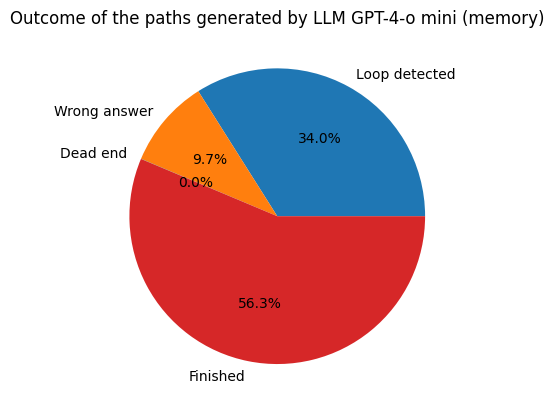

In [56]:
# get the pie chart of the outcome of the llm run with memory
llm_paths_all_gpt4omini_memory_LD = llm_paths_all_gpt4omini_memory[llm_paths_all_gpt4omini_memory['path'].apply(lambda x: x.split(';')[-1] == 'LOOP_DETECTED')]
llm_paths_all_gpt4omini_memory_WA = llm_paths_all_gpt4omini_memory[llm_paths_all_gpt4omini_memory['path'].apply(lambda x: x.split(';')[-1] == 'WRONG_ANSWER')]
llm_paths_all_gpt4omini_memory_NL = llm_paths_all_gpt4omini_memory[llm_paths_all_gpt4omini_memory['path'].apply(lambda x: x.split(';')[-1] == 'NO_LINK')]
llm_paths_all_gpt4omini_memory_finished = llm_paths_all_gpt4omini_memory[llm_paths_all_gpt4omini_memory['path'].apply(lambda x: x.split(';')[-1] not in ['LOOP_DETECTED', 'WRONG_ANSWER', 'NO_LINK'])]

print("The number of finished paths ",len(llm_paths_all_gpt4omini_memory_finished))
print("The number of loop detected ",len(llm_paths_all_gpt4omini_memory_LD))
print("The number of wrong answer ",len(llm_paths_all_gpt4omini_memory_WA))
print("The number of dead end ",len(llm_paths_all_gpt4omini_memory_NL))

# pie chart of the outcome of the paths
labels = 'Loop detected', 'Wrong answer', 'Dead end', 'Finished'
sizes = [len(llm_paths_all_gpt4omini_memory_LD), len(llm_paths_all_gpt4omini_memory_WA), len(llm_paths_all_gpt4omini_memory_NL), len(llm_paths_all_gpt4omini_memory_finished)]
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Outcome of the paths generated by LLM GPT-4-o mini (memory)')
plt.show()

Does the llm take on average more steps than the human?

In [57]:
# To compare the number of steps taken we need to filtered only the unfinished paths to get comparable fata
# filter out the rows with 0 steps to filter the unfinished paths
llm_paths_all_gpt4omini_memory = llm_paths_all_gpt4omini_memory[llm_paths_all_gpt4omini_memory['steps'] > 0]
# describe the data
llm_paths_all_gpt4omini_memory['steps'].describe()

count    7552.000000
mean        6.983316
std         4.778942
min         1.000000
25%         4.000000
50%         6.000000
75%         9.000000
max        57.000000
Name: steps, dtype: float64

In [58]:
# create a column path_lengts counting the number of steps for each finished path
llm_paths_all_gpt4omini_memory['path_length'] = llm_paths_all_gpt4omini_memory['path'].apply(lambda x: len(x.split(';')) - 1)

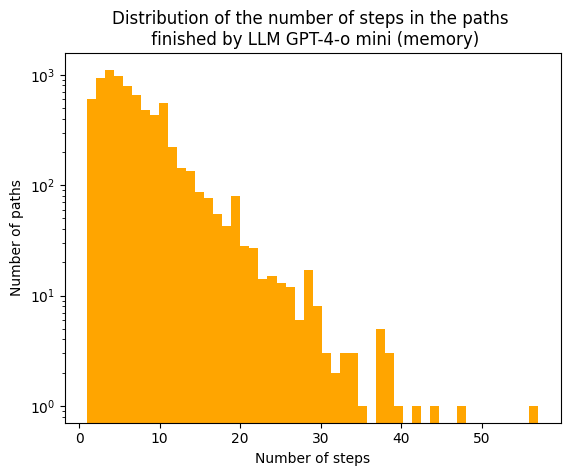

In [ ]:
# plot the distribution of the number of steps in the finished paths
llm_paths_all_gpt4omini_memory['path_length'].hist(color='orange', bins=50)
plt.xlabel('Number of steps')
plt.ylabel('Number of paths')
plt.title('Distribution of the number of steps in the paths \n finished by LLM GPT-4-o mini (memory)')
plt.grid(False)
plt.yscale('log')

In [ ]:
# To have a good comparaison it is nice to compare similar paths. This is why we take only the path_id that are in the 2 datasets
# create a mask using the past_id column
mask = paths_finished['path_id'].isin(llm_paths_all_gpt4omini_memory['path_id'])
paths_finished_filtered = paths_finished[mask]


# get the number of steps in the filtered paths
paths_finished_filtered['path_length'] = paths_finished_filtered['path'].apply(lambda x: len(x.split(';')) - 1)
paths_finished_filtered['path_length'].describe()


C:\Users\ghita\AppData\Local\Temp\ipykernel_28420\695916232.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paths_finished_filtered['path_length'] = paths_finished_filtered['path'].apply(lambda x: len(x.split(';')) - 1)


count    7552.000000
mean        5.566870
std         6.244099
min         1.000000
25%         3.000000
50%         5.000000
75%         6.000000
max       434.000000
Name: path_length, dtype: float64

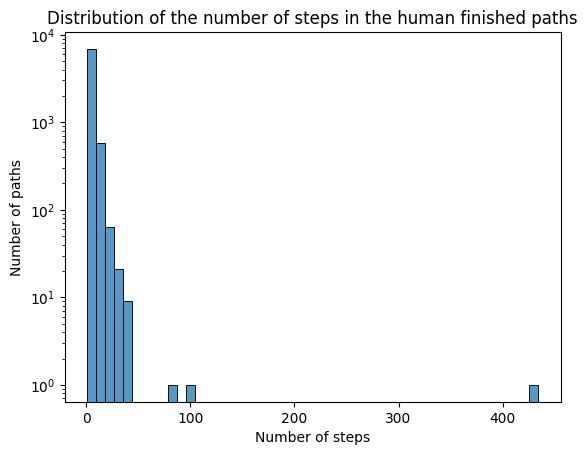

In [61]:
# plot the distribution of the number of steps in the filtered paths
sns.histplot(paths_finished_filtered['path_length'], bins=50)
plt.title('Distribution of the number of steps in the human finished paths')
plt.xlabel('Number of steps')
plt.ylabel('Number of paths')
plt.yscale('log')

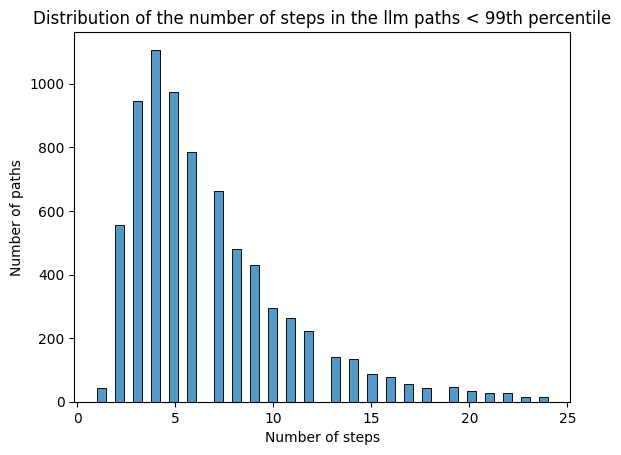

In [ ]:
# we clearly see the existence of outliers. We therefore get the 99th percentile of the number of steps in the llm paths with memory
percentile_99 = np.percentile(llm_paths_all_gpt4omini_memory['path_length'], 99)

# plot the distribution of the number of steps in the llm paths that are less than the 90th percentile
llm_paths_all_gpt4omini_memory_lt_99 = llm_paths_all_gpt4omini_memory[llm_paths_all_gpt4omini_memory['path_length'] < percentile_99]
sns.histplot(llm_paths_all_gpt4omini_memory_lt_99['path_length'], bins=50)
plt.title('Distribution of the number of steps in the llm paths < 99th percentile')
plt.xlabel('Number of steps')
plt.ylabel('Number of paths')
plt.show()

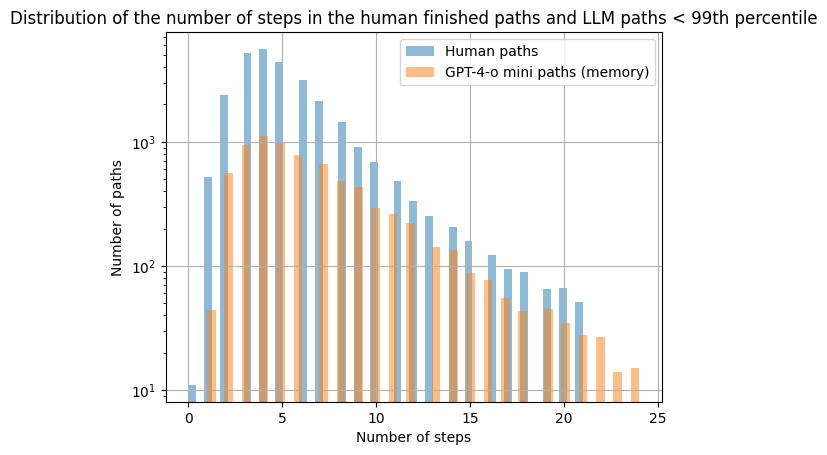

In [ ]:
# compare the distribution of the number of steps in the finished paths filtered 99 percentile and the LLM paths filtered 99 percentile
paths_finished_filtered_lt_99['path_length'].hist(bins=50, alpha=0.5, label='Human paths')
llm_paths_all_gpt4omini_memory_lt_99['path_length'].hist(bins=50, alpha=0.5, label='GPT-4-o mini paths (memory)')
plt.title('Distribution of the number of steps in the human finished paths and LLM paths < 99th percentile')
plt.xlabel('Number of steps')
plt.ylabel('Number of paths')
plt.legend()
plt.yscale('log')
plt.show()

What is the distribution of the categories of articles passed by the llm or by the human?

In [65]:
# we reload to get the unfiltered dataset
llm_paths_all_gpt4omini_memory = pd.read_csv('data/llm_paths_all_gpt4omini_memory.tsv', sep='\t')

In [66]:
# get the articles that human goes to
articles_llm = llm_paths_all_gpt4omini_memory['path'].apply(lambda x: x.split(';')).tolist()

# ignore the "<" articles in the path
articles_llm = [[item for item in sublist if item[0] != '<'] for sublist in articles_llm]

# get the categories of the articles
file_path = "data/wikispeedia_paths-and-graph/categories.tsv"
categories = pd.read_csv(file_path, sep='\t', skiprows=12, names=['article', 'category'])
categories = categories.map(urllib.parse.unquote)

articles_llm = [item for sublist in articles_llm for item in sublist]
# get the categories of the articles
categories_of_articles_llm = []
for article in articles_llm:
    try:
        categories_of_articles_llm.append(categories[categories['article'] == article]['category'])
    except:
        pass


# using the value counts, get the 0.70 quantile of the categories
categories_of_articles_llm = [item for sublist in categories_of_articles_llm for item in sublist]
categories_count_llm = pd.Series(categories_of_articles_llm).value_counts()

# print the 5 most common categories
print(categories_count_llm.head())
nbr = categories_count_llm.quantile(0.70)

subject.Countries                                                  13368
subject.Science.Biology.General_Biology                             7519
subject.History.Ancient_History_Classical_History_and_Mythology     4973
subject.Geography.European_Geography.European_Countries             4754
subject.Citizenship.Politics_and_government                         4139
Name: count, dtype: int64


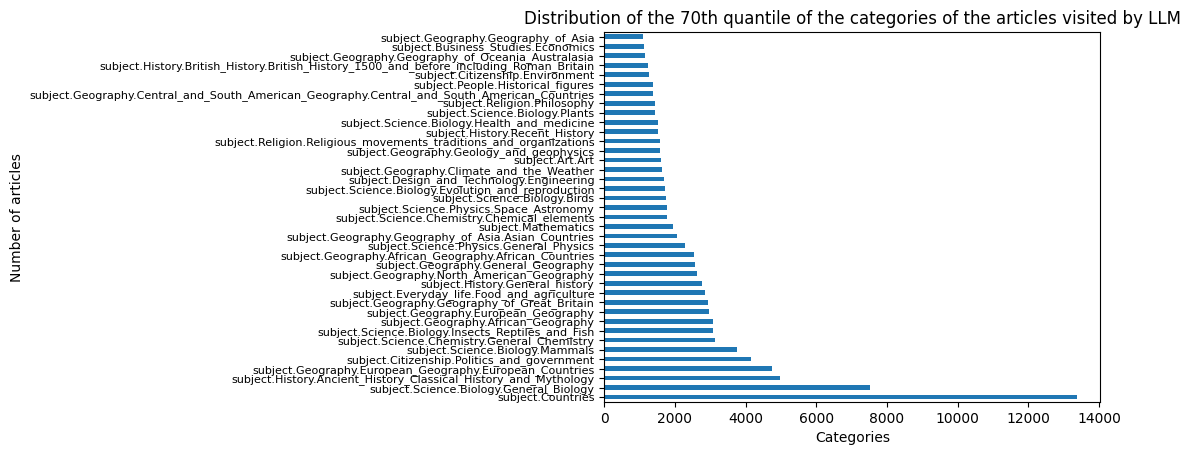

In [67]:
# plot the distribution of the 70th quantile
categories_count_llm[categories_count_llm > nbr].plot(kind='barh')
plt.title('Distribution of the 70th quantile of the categories of the articles visited by LLM')
plt.ylabel('Number of articles')
plt.xlabel('Categories')
plt.yticks(fontsize=8)
plt.show()

In [73]:
# get the articles that human goes to
articles_human = paths_finished['path'].apply(lambda x: x.split(';')).tolist()

# ignore the "<" articles in the path
articles_human = [[item for item in sublist if item[0] != '<'] for sublist in articles_human]


articles_human = [item for sublist in articles_human for item in sublist]
# get the cartegoies of the articles
categories_of_articles_human = []
for article in articles_human:
    try:
        categories_of_articles_human.append(categories[categories['article'] == article]['category'])
    except:
        pass


# using the value counts, get the 0.70 quantile of the categories
categories_of_articles_human = [item for sublist in categories_of_articles_human for item in sublist]
categories_count_human = pd.Series(categories_of_articles_human).value_counts()

# print the 5 most common categories
print(categories_count_human.head())
nbr_h = categories_count_human.quantile(0.70)

subject.Countries                                          25739
subject.Geography.North_American_Geography                 10157
subject.Geography.European_Geography.European_Countries     9503
subject.Geography.Geography_of_Great_Britain                8169
subject.Geography.General_Geography                         6106
Name: count, dtype: int64


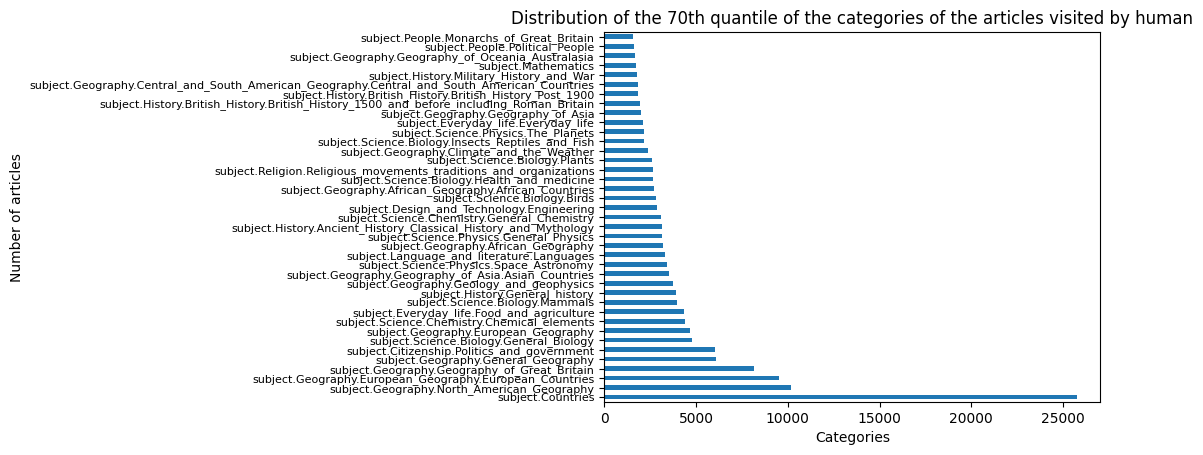

In [69]:
# plot the distribution of the 70th quantile
categories_count_human[categories_count_human > nbr_h].plot(kind='barh')
plt.title('Distribution of the 70th quantile of the categories of the articles visited by human')
plt.ylabel('Number of articles')
plt.xlabel('Categories')
plt.yticks(fontsize=8)
plt.show()

Now we compare the articles passed by the llm and the human. Does the llm pass more articles than the human?

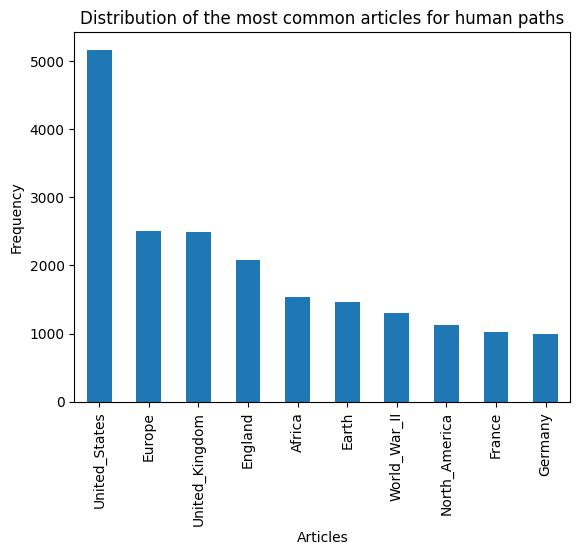

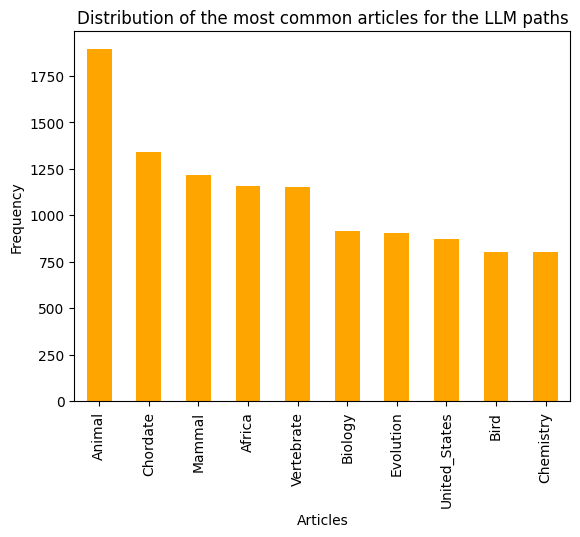

In [70]:

# Plot the distribution of the most common articles
articles_count_h = pd.Series(articles_human)
articles_count_h = articles_count_h.value_counts()
articles_count_h = articles_count_h.sort_values(ascending=False)
articles_count_h = articles_count_h[:10]
articles_count_h.plot(kind='bar')
plt.title('Distribution of the most common articles for human paths')
plt.xlabel('Articles')
plt.ylabel('Frequency')
plt.show()


# from articles_llm, drop the loop_detected, wrong_answer and no_link
articles_llm = [item for item in articles_llm if item not in ['LOOP_DETECTED', 'WRONG_ANSWER', 'NO_LINK']]


# Plot the distribution of the most common articles
articles_count = pd.Series(articles_llm)
articles_count = articles_count.value_counts()
articles_count = articles_count.sort_values(ascending=False)
articles_count = articles_count[:10]
articles_count.plot(kind='bar', color='orange')
plt.title('Distribution of the most common articles for the LLM paths')
plt.xlabel('Articles')
plt.ylabel('Frequency')
plt.show()

